In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import choice,shuffle
from scipy import stats as st

from collections import deque

In [6]:
def gather_data(num_samples):
    
    global rock, paper, scissor, nothing
    
    # Initialize the camera
    cap = cv2.VideoCapture(0)

    # trigger tells us when to start recording
    trigger = False
    
    # Counter keeps count of the number of samples collected
    counter = 0
    
    # This the ROI size, the size of images saved will be box_size -10
    box_size = 234
    
    # Getting the width of the frame from the camera properties
    width = int(cap.get(3))


    while True:
        
        # Read frame by frame
        ret, frame = cap.read()
        
        # Flip the frame laterally
        frame = cv2.flip(frame, 1)
        
        # Break the loop if there is trouble reading the frame.
        if not ret:
            break
            
        # If counter is equal to the number samples then reset triger and the counter
        if counter == num_samples:
            trigger = not trigger
            counter = 0
        
        # Define ROI for capturing samples
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
        # Make a resizable window.
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
        
        
        # If trigger is True than start capturing the samples
        if trigger:
            
            # Grab only slected roi
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
            
            # Append the roi and class name to the list with the selected class_name
            eval(class_name).append([roi, class_name])
                                    
            # Increment the counter 
            counter += 1 
        
            # Text for the counter
            text = "Collected Samples of {}: {}".format(class_name, counter)
            
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
        
        # Show the counter on the imaege
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
        
        # Display the window
        cv2.imshow("Collecting images", frame)
        
        # Wait 1 ms
        k = cv2.waitKey(1)
        
        # If user press 'r' than set the path for rock directoryq
        if k == ord('r'):
            
            # Trigger the variable inorder to capture the samples
            trigger = not trigger
            class_name = 'rock'
            rock = []
           
            
        # If user press 'p' then class_name is set to paper and trigger set to True  
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
        
        # If user press 's' then class_name is set to scissor and trigger set to True  
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
                    
        # If user press 's' then class_name is set to nothing and trigger set to True
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
        
        # Exit if user presses 'q'
        if k == ord('q'):
            break
            
    #  Release the camera and destroy the window
    cap.release()
    cv2.destroyAllWindows()

In [7]:
no_of_samples = 100
gather_data(no_of_samples)

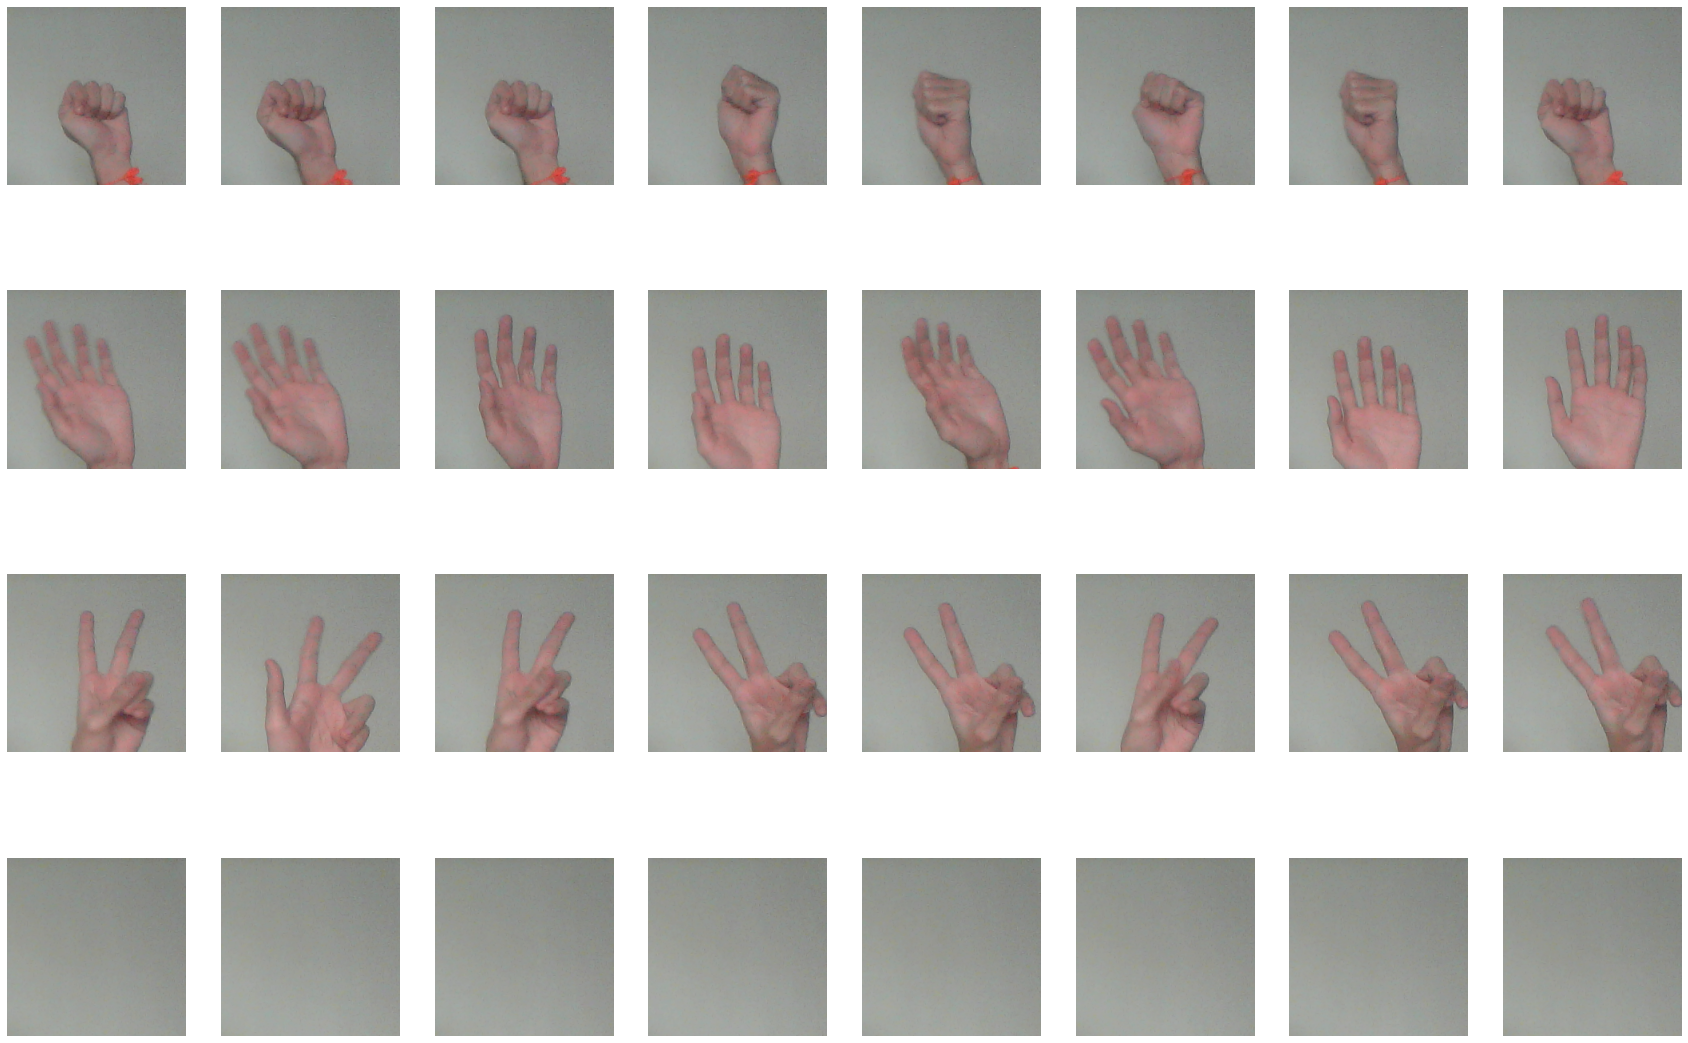

In [8]:
# Set the figure size
plt.figure(figsize=[30,20])

# Set the rows and columns
rows, cols = 4, 8

# Iterate for each class
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
    
    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(no_of_samples, size=8);
    
    # Plot the examples
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');

In [9]:
# Combine the labels of all classes together
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]

# Combine the images of all classes together
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]

# Normalize the images by dividing by 255, now our images are in range 0-1. This will help in training.
images = np.array(images, dtype="float") / 255.0

# Print out the total number of labels and images.
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))

# Create an encoder Object
encoder = LabelEncoder()

# Convert Lablels to integers. i.e. nothing = 0, paper = 1, rock = 2, scissor = 3 (mapping is done in alphabatical order)
Int_labels = encoder.fit_transform(labels)

# Now the convert the integer labels into one hot format. i.e. 0 = [1,0,0,0]  etc.
one_hot_labels = to_categorical(Int_labels, 4)

# Now we're splitting the data, 75% for training and 25% for testing.
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)

# Empty memory from RAM
images = []


# This can further free up memory from RAM but be careful, if you won't be able to change split % after this.
# rock, paper, scissor = [], [], []

Total images: 400 , Total Labels: 400


In [10]:
# This is the input size which our model accepts.
image_size = 224

# Loading pre-trained NASNETMobile Model without the head by doing include_top = False
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Freeze the whole model 
N_mobile.trainable = False
    
# Adding our own custom head
# Start by taking the output feature maps from NASNETMobile
x = N_mobile.output

# Convert to a single-dimensional vector by Global Average Pooling. 
# We could also use Flatten()(x) GAP is more effective reduces params and controls overfitting.
x = GlobalAveragePooling2D()(x)

# Adding a dense layer with 712 units
x = Dense(712, activation='relu')(x) 

# Dropout 40% of the activations, helps reduces overfitting
x = Dropout(0.40)(x)

# The fianl layer will contain 4 output units (no of units = no of classes) with softmax function.
preds = Dense(4,activation='softmax')(x) 

# Construct the full model
model = Model(inputs=N_mobile.input, outputs=preds)

# Check the number of layers in the final Model
print ("Number of Layers in Model: {}".format(len(model.layers[:])))

19996672/19993432 [==============================] - 9s 0us/step
Number of Layers in Model: 773


In [11]:
# Adding transformations that I know would help, you can feel free to add more.
# I'm doing horizontal_flip = False, in case you aren't sure which hand you would be using you can make that True.

augment = ImageDataGenerator( 
    
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Set batchsize according to your system
epochs = 15
batchsize = 20

# Start training
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

# Use model.fit_generator function instead if TF version < 2.2
#history = model.fit_generator(x = augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
#steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
15/15 [==============================] - 38s 3s/step - loss: 0.9826 - accuracy: 0.6067 - val_loss: 0.5586 - val_accuracy: 0.8900
Epoch 2/15
15/15 [==============================] - 32s 2s/step - loss: 0.4492 - accuracy: 0.8967 - val_loss: 0.2753 - val_accuracy: 0.9800
Epoch 3/15
15/15 [==============================] - 32s 2s/step - loss: 0.2537 - accuracy: 0.9700 - val_loss: 0.2072 - val_accuracy: 0.9600
Epoch 4/15
15/15 [==============================] - 32s 2s/step - loss: 0.1692 - accuracy: 0.9767 - val_loss: 0.1344 - val_accuracy: 0.9800
Epoch 5/15
15/15 [==============================] - 32s 2s/step - loss: 0.1463 - accuracy: 0.9733 - val_loss: 0.1207 - val_accuracy: 0.9800
Epoch 6/15
15/15 [==============================] - 32s 2s/step - loss: 0.1136 - accuracy: 0.9833 - val_loss: 0.0874 - val_accuracy: 0.9800
Epoch 7/15
15/15 [==============================] - 32s 2s/step - loss: 0.0958 - accuracy: 0.9867 - val_loss: 0.0906 - val_accuracy: 0.9800
Epoch 8/15
15/15 [==

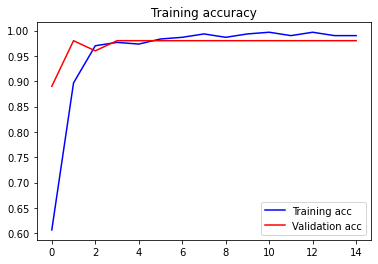

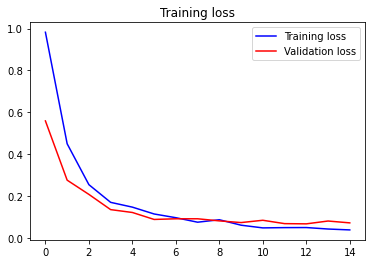

In [14]:
# Plot the accuracy and loss curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [15]:
model.save("rps4.h5")

In [8]:
model = load_model("rps4.h5")

In [17]:
# This list will be used to map probabilities to class names, Label names are in alphabetical order.
label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

while True:
    
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
           
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    # Normalize the image like we did in the preprocessing step, also convert float64 array.
    roi = np.array([roi]).astype('float64') / 255.0
 
    # Get model's prediction.
    pred = model.predict(roi)
    
    # Get the index of the target class.
    target_index = np.argmax(pred[0])

    # Get the probability of the target class
    prob = np.max(pred[0])

    # Show results
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    
    cv2.imshow("Rock Paper Scissors", frame)
    
   
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [18]:
def findout_winner(user_move, Computer_move):
    
    # All logic below is self explanatory 
    
    if user_move == Computer_move:
        return "Tie"    
    
    elif user_move == "rock" and Computer_move == "scissor":
        return "User"
    
    elif user_move == "rock" and Computer_move == "paper":
        return "Computer"
    
    elif user_move == "scissor" and Computer_move == "rock":
        return "Computer"
    
    elif user_move == "scissor" and Computer_move == "paper":
        return "User"
    
    elif user_move == "paper" and Computer_move == "rock":
        return "User"
    
    elif user_move == "paper" and Computer_move == "scissor":
        return "Computer"

In [19]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])

winner = findout_winner(user_move, computer_move)

print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'scissor' , winner is: 'Computer' 


In [20]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])

winner = findout_winner(user_move, computer_move)

print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'rock' , winner is: 'User' 
